***Importing libraries***

In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from string import punctuation

#stop = list(stopwords.words('english'))

from tqdm import tqdm_notebook
tqdm_notebook().pandas()

import re
from functools import reduce

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
!pip install fuzzywuzzy

import pandas as pd
import numpy as np

import operator
from fuzzywuzzy import process
from fuzzywuzzy import fuzz

from sklearn.metrics.pairwise import cosine_similarity

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
!pip install gensim

import gensim 
from gensim.models import Word2Vec

In [ ]:
!git clone https://github.com/smirnov-am/pytopicrank.git

%cd /content/pytopicrank/

!pip install -r requirements.txt

from pytopicrank import TopicRank

Cloning into 'pytopicrank'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 73 (delta 2), reused 0 (delta 0), pack-reused 65
Unpacking objects: 100% (73/73), done.
/content/pytopicrank
     |████████████████████████████████| 1.0MB 4.5MB/s 
     |████████████████████████████████| 1.6MB 12.9MB/s 
     |████████████████████████████████| 4.9MB 17.5MB/s 
     |████████████████████████████████| 9.5MB 42.8MB/s 
     |████████████████████████████████| 15.2MB 320kB/s 
  Created wheel for langdetect: filename=langdetect-1.0.7-cp37-none-any.whl size=993460 sha256=c1ff3672d7b9ac7a80cdb3f41f25f327e54ebc60379d5781df397cc108ab7c70
  Stored in directory: /root/.cache/pip/wheels/ec/0c/a9/1647275e7ef5014e7b83ff30105180e332867d65e7617ddafe
  Created wheel for networkx: filename=networkx-2.1-py2.py3-none-any.whl size=1447766 sha256=0c4e65b617c1f6823c0f44f2ee7df282ddaf2f254a0d14e03a64cc5b2f7bb19e
  Stored in di

**Step-1: Importing dataset**

---


We import the dataset first. It consists of various YouTube videos: their names, the content of the videos and their URLs.

In [ ]:
stop = []

f = open(r'/content/STOPWORDS.txt', 'r')
for l in f.readlines():
    stop.append(l.replace('\n', ''))

additional_stop_words = ['video', 'videos']
stop += additional_stop_words

In [ ]:
import pandas as pd

df = pd.read_csv(r"/content/video embedding.csv")
df.head()

,Name,YouTube URL,Video Embedding
0,A brief history of chess - Alex Gendler,https://www.youtube.com/watch?app=desktop&v=Ye...,the attacking infantry advances steadily that...
1,Building Knowledge Graphs in 10 Steps,https://www.youtube.com/watch?app=desktop&v=lU...,building knowledge graphs in ten steps step ...
2,Cancer - Treatment Diagnosis Types of Tumors ...,https://www.youtube.com/watch?app=desktop&v=6R...,Kenseth descended dumps carousel but it sure...
3,Data Science In 5 Minutes Data Science For Be...,https://www.youtube.com/watch?v=X3paOmcrTjQ,are you one of the many who dreams of becomin...
4,Data Types vs Abstract Data Types,https://www.youtube.com/watch?app=desktop&v=Zn...,you know the journey towards learning data st...


In [ ]:
df['Name'][48]

'World War I (short version)'

In [ ]:
df['Video Embedding'][48]

" one hundred years ago ended a war whose intensity and scale the wood had never before seen a war that involves more than sixty million soldiers around the globe in this video we retrace the origins events and consequences of World War one  to understand the origins of World War one we started in eighteen seventy one at the end of the Franco German war between the French empire and the confederation of north Germany allied with the German states of the south after six months of fighting fronts is defeated and the victors unite to form the German empire as us and we said our findings to the new empire frustrating the French side  in the following years Germany would greatly advance IT industry and economy the country also bids and I Ince's first with the Austro Hungarian empire and then with it to be which is frustrated by France colonizing Tunisia the three phone the triplets for triple alliance growing in power and status Germany begins colonizing African tied to trees for its part f

**Step-2: Preprocessing the data**

---

The contents of the videos in the dataset are cleaned before futher steps. Non ASCII characters are removed and further cleaning is done using regex. The sentences are then tokenized using the nltk library and stopwords are removed.

In [ ]:
def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]+', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    return text

In [ ]:
def tokenizer(text):
    text = clean_text(text)    
    tokens = [word_tokenize(sent) for sent in sent_tokenize(text)]
    tokens = list(reduce(lambda x,y: x+y, tokens))
    tokens = list(filter(lambda token: token not in (stop + list(punctuation)) , tokens))
    return tokens

In [ ]:
tokens1 = df['Video Embedding'].progress_map(lambda d: tokenizer(d))
tokens2 = df['Name'].progress_map(lambda d: tokenizer(d))

In [ ]:
df['tokens'] = tokens2+tokens1

In [ ]:
df.head()

,Name,YouTube URL,Video Embedding,tokens
0,A brief history of chess - Alex Gendler,https://www.youtube.com/watch?app=desktop&v=Ye...,the attacking infantry advances steadily that...,"[history, chess, alex, gendler, attacking, inf..."
1,Building Knowledge Graphs in 10 Steps,https://www.youtube.com/watch?app=desktop&v=lU...,building knowledge graphs in ten steps step ...,"[building, knowledge, graphs, steps, building,..."
2,Cancer - Treatment Diagnosis Types of Tumors ...,https://www.youtube.com/watch?app=desktop&v=6R...,Kenseth descended dumps carousel but it sure...,"[cancer, treatment, diagnosis, types, tumors, ..."
3,Data Science In 5 Minutes Data Science For Be...,https://www.youtube.com/watch?v=X3paOmcrTjQ,are you one of the many who dreams of becomin...,"[data, science, minutes, data, science, beginn..."
4,Data Types vs Abstract Data Types,https://www.youtube.com/watch?app=desktop&v=Zn...,you know the journey towards learning data st...,"[data, types, abstract, data, types, journey, ..."


In [ ]:
dx = df.iloc[29]

In [ ]:
dx

In [ ]:
len(list(dx['tokens']))

6

**Step-3: Visualizing the Data**

---


***TF-IDF*** or Term Frequency Inverse Document Frequency is used to find frequency of occurences of various words in the paragraphs. We can see the document-term matrix or use these frequencies to plot a ***WordCloud***, a visual representation of words based on the frequency of occurence.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=10, min_df = 1, analyzer='word', ngram_range=(1, 2), stop_words='english')
tdm = vectorizer.fit_transform([(' '.join(w for w in dx['tokens']))])
#tdm = vectorizer.fit_transform(list(dx['tokens'].map(lambda tokens: ' '.join(tokens))))

In [ ]:
tdm.shape

(6, 2286)

In [ ]:
feature_names = vectorizer.get_feature_names()
dtdm = pd.DataFrame(tdm.T.todense(), index=feature_names)

In [ ]:
dtdm

,0
anderson,0.033691
anderson light,0.033691
anonymous,0.033691
anonymous subject,0.033691
ball,0.033691
...,...
wanted intuitive,0.033691
wo,0.033691
wo formation,0.033691
wood,0.033691


In [ ]:
vectorizer.vocabulary_.items()

dict_items([('reflection', 176), ('light', 98), ('dont', 38), ('memorise', 121), ('things', 209), ('ice', 80), ('help', 68), ('objects', 150), ('dark', 32), ('need', 133), ('object', 144), ('coming', 27), ('source', 186), ('fluorescent', 55), ('bulb', 20), ('book', 13), ('emitting', 42), ('emit', 40), ('limit', 115), ('examples', 46), ('anderson', 0), ('sun', 202), ('stars', 192), ('humanness', 77), ('stable', 190), ('called', 23), ('numinous', 139), ('wood', 218), ('plastic', 164), ('cotton', 30), ('metal', 123), ('moon', 130), ('planets', 162), ('humanist', 74), ('night', 135), ('reason', 168), ('luminous', 119), ('simply', 182), ('referred', 170), ('change', 25), ('direction', 34), ('flight', 52), ('bouncing', 18), ('surface', 204), ('ball', 4), ('bounces', 15), ('ground', 64), ('reflects', 178), ('smooth', 184), ('explain', 48), ('simple', 180), ('strikes', 194), ('reaches', 166), ('nonhuman', 137), ('mirror', 127), ('image', 84), ('formed', 61), ('dock', 36), ('wo', 216), ('format

In [ ]:
from wordcloud import WordCloud, STOPWORDS 
from matplotlib import pyplot as plt

weights = [(word, tdm.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()]
weights = dict(weights)
[weights]

[{'anderson': 0.03369085602646046,
  'anderson light': 0.03369085602646046,
  'anonymous': 0.03369085602646046,
  'anonymous subject': 0.03369085602646046,
  'ball': 0.03369085602646046,
  'ball bounces': 0.03369085602646046,
  'beaches': 0.03369085602646046,
  'beaches ice': 0.03369085602646046,
  'body': 0.13476342410584183,
  'body emit': 0.03369085602646046,
  'body humanist': 0.03369085602646046,
  'body reflected': 0.03369085602646046,
  'body time': 0.03369085602646046,
  'book': 0.03369085602646046,
  'book emitting': 0.03369085602646046,
  'bounces': 0.06738171205292091,
  'bounces ground': 0.03369085602646046,
  'bounces surface': 0.03369085602646046,
  'bouncing': 0.03369085602646046,
  'bouncing flight': 0.03369085602646046,
  'bulb': 0.06738171205292091,
  'bulb book': 0.03369085602646046,
  'bulb sun': 0.03369085602646046,
  'called': 0.03369085602646046,
  'called numinous': 0.03369085602646046,
  'change': 0.03369085602646046,
  'change direction': 0.03369085602646046,


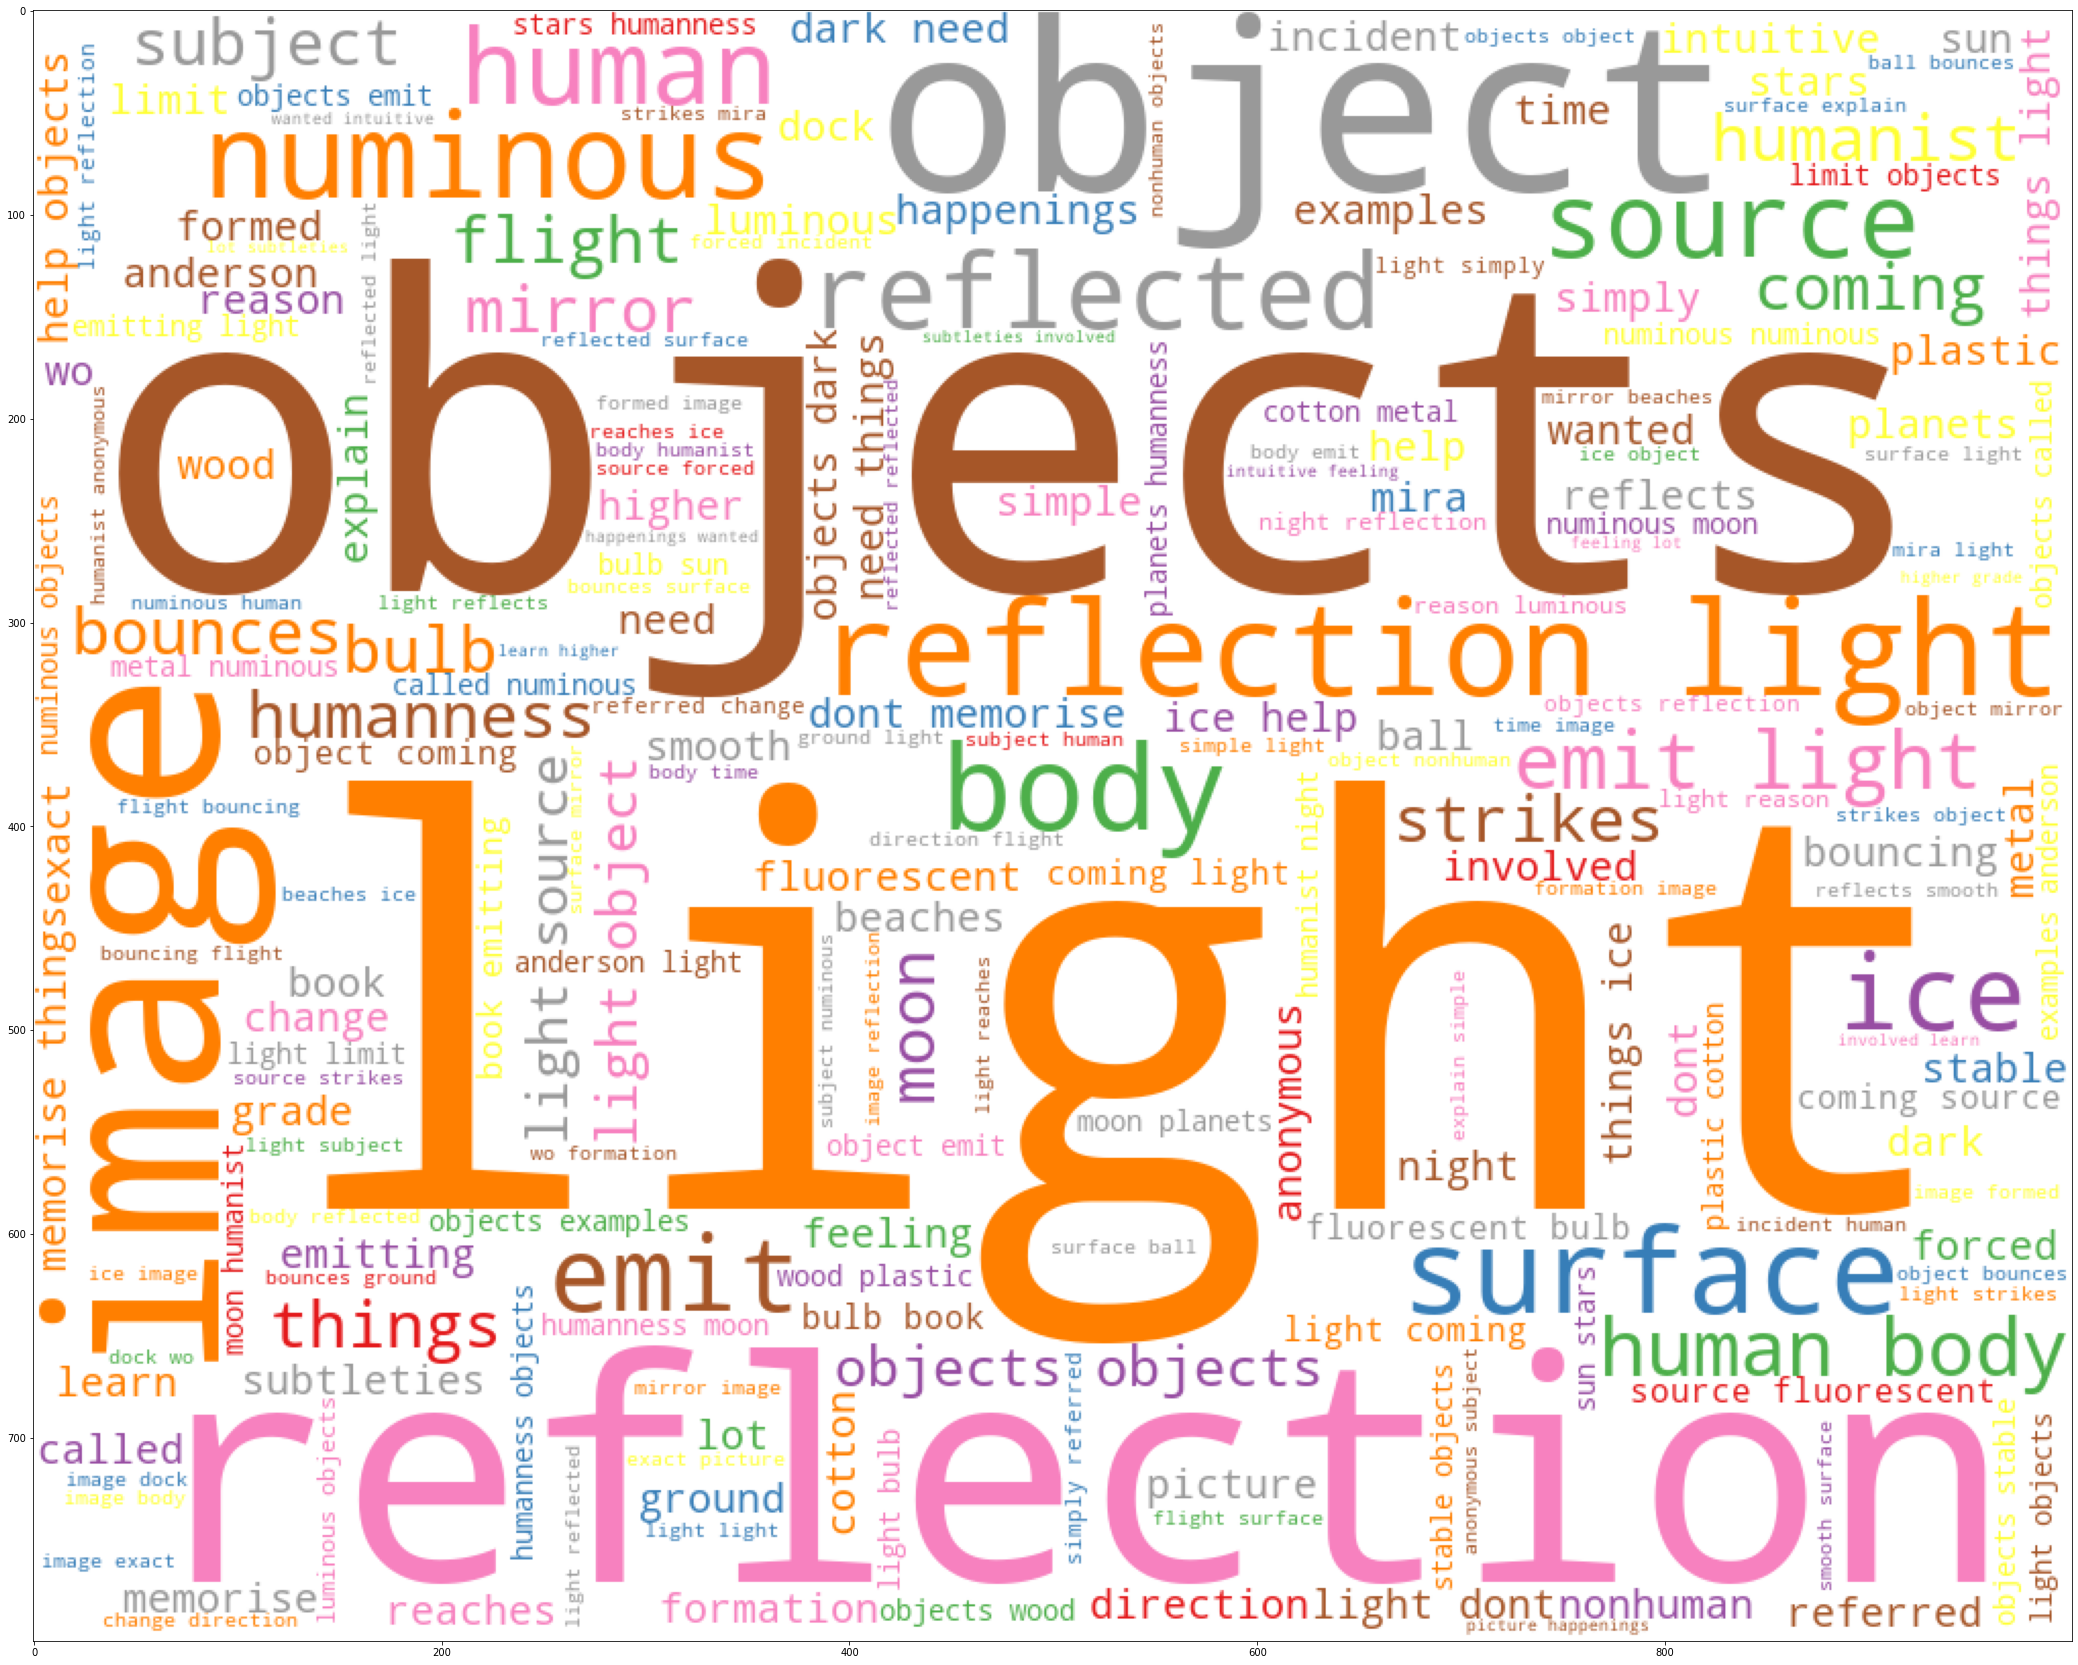

In [ ]:
w = WordCloud(width=1000,height=800,background_color='white', colormap='Set1',max_words=2000).fit_words(weights)
plt.figure(figsize=(40, 30))
plt.imshow(w)
plt.show()



---





---



***How to use Spacy's Named Entity Recognition***

The Spacy NER system contains a word embedding strategy using sub word features and "Bloom" embed, and a deep convolution neural network with residual connections.

Spacy has the ‘ner’ pipeline component that identifies token spans fitting a predetermined set of named entities. These are available as the ‘ents’ property of a Doc object.

Let's look at the different tags available in the ner model of spacy.


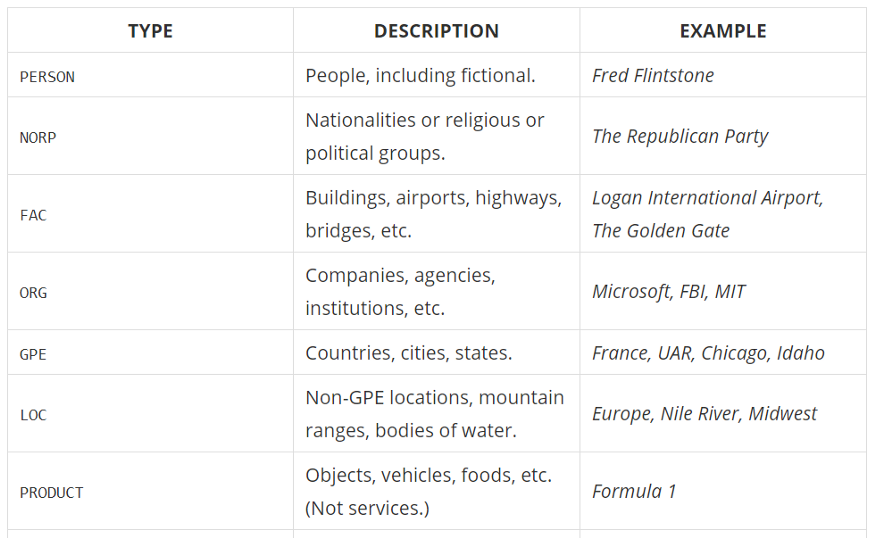

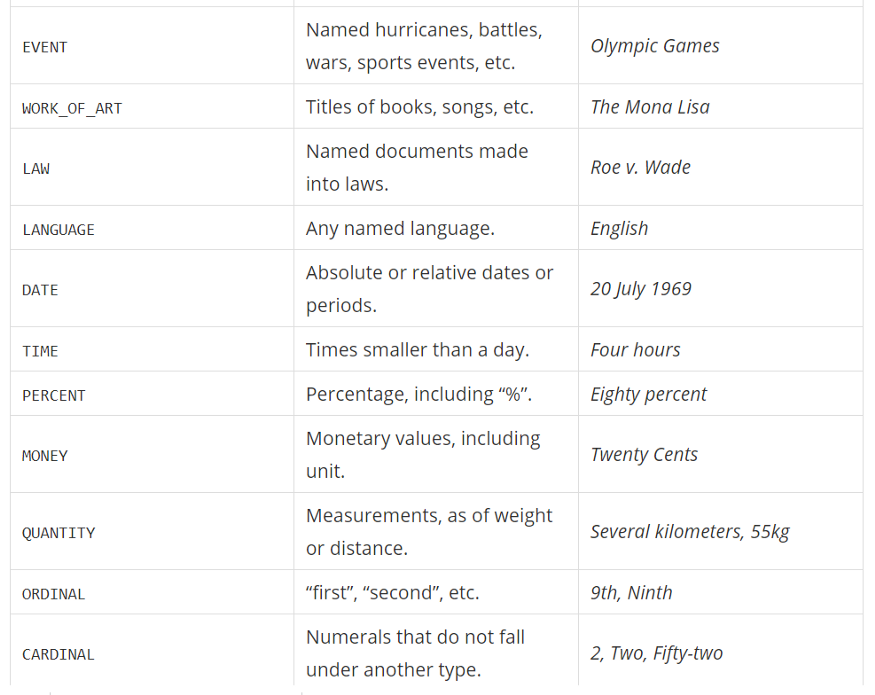

In [ ]:
import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_sm')

In [ ]:
text = "at around 7 am on a quiet Wednesday in August 2017, Marcus Hutchins walked out the front door of the Airbnb mansion in Las Vegas where he had been partying for the past week and a half. A gangly, 23-year-old hacker with an explosion of blond-brown curls, Hutchins had emerged to retrieve his order of a Big Mac and fries from an Uber Eats deliveryman. But as he stood barefoot on the mansions driveway wearing only a T-shirt and jeans, Hutchins noticed a black SUV parked on the street— that looked very much like an FBI stakeout."
doc = nlp(text)

In [ ]:
text

In [ ]:
if doc.ents:
    for ent in doc.ents:
        print("{}: {}".format(ent.text, ent.label_))

In [ ]:
displacy.render(doc, style='ent', jupyter=True, options={'distance': 90})

***Using Spacy's noun-phrase extraction***

This is based on the syntax and grammar Spacy can identify.

In [ ]:
for chunk in doc.noun_chunks:
    print(chunk.text)

***Using TopicRank for Key-phrase extraction***

A graph based keyphrase extraction method

In [ ]:
tr = TopicRank(text)
tr.get_top_n(n=8, extract_strategy='first')



---





---



# **Search Engine on Videos**

---

---





**Extracting entities from texts**

---

Three methods have been combined for extracting entities from the query and video contents. 

1.   *Spacy's Named Entity Recognition*
2.   *Spacy's noun phrase extraction*
3.   *Topicrank for keyphrase extraction*



In [ ]:
def spacy_nounphrase(text):
    ent = []
    doc = nlp(text)
    for chunk in doc.noun_chunks:
        ent.append(str(chunk.text))
    return ent

def ner_spacy(text):
    entities = []
    doc = nlp(text)
    if doc.ents:
        for ent in doc.ents:
            entities.append(ent.text)
    return entities

def ent_topicrank(text, no_of_tokens):
    try:
        tr = TopicRank(text)
        ent = tr.get_top_n(n=no_of_tokens, extract_strategy='first')
        return ent
    except:
        return []


def extract_entities(text, stop_words):
    tokens = word_tokenize(text)
    ent1 = ent_topicrank(text, len(tokens))
    ent2 = spacy_nounphrase(text)
    ent3 = ner_spacy(text)
    ents = list(set(ent1+ent2+ent3))
    entities_ = list(x.lower() for x in ents)
    entities = [word for word in entities_ if word not in stop_words]
    return entities

In [ ]:
doc = []
title_all = []
title_ent = []
body_all = []
body_ent = []
for index, rows in df.iterrows():
    sent = []
    title_all_ = rows[0].split()
    t_all = list(x.lower() for x in title_all_)
    title_all = [w for w in t_all if w not in stop]
    title = extract_entities(rows[0], stop)
    body_all_ = rows[2].split()
    b_all = list(x.lower() for x in body_all_)
    body_all = [w for w in b_all if w not in stop]
    body = extract_entities(rows[2], stop)
    title_ent.append(title)
    body_ent.append(body)
    title += title_all
    body += body_all
    sent = title+body
    doc.append(sent)

2021-03-26 07:58:32,435: DEBUG: Detected en language
2021-03-26 07:58:32,436: DEBUG: Using <class 'nltk.stem.snowball.SnowballStemmer'> stemmer
2021-03-26 07:58:32,552: DEBUG: Found 2 keyphrases
/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))
2021-03-26 07:58:32,559: DEBUG: Found 2 keyphrase clusters (topics)
2021-03-26 07:58:32,621: DEBUG: Detected en language
2021-03-26 07:58:32,623: DEBUG: Using <class 'nltk.stem.snowball.SnowballStemmer'> stemmer
2021-03-26 07:58:32,673: DEBUG: Found 165 keyphrases
2021-03-26 07:58:32,738: DEBUG: Found 149 keyphrase clusters (topics)
2021-03-26 07:58:33,760: DEBUG: Detected en language
2021-03-26 07:58:33,761: DEBUG: Using <class 'nltk.stem.snowball.SnowballStemmer'> stemmer
2021-03-26 07:58:33,764: DEBUG: Found 2 keyphrases
2021-03-26 07:58:33,767: DEBUG: Found 2 keyphrase clusters (topics)
2021-03-26 0

**Matching extracted entities of query with videos**

---


After having extracted the entities from the queries and video content, we need to match them to find the most relevant videos. Two approaches has been combined here:


1. A string matching algorithm using *FuzzyWuzzy* package.
2. A Deep Learning based approach which generates word embeddings- *Word2Vec*.

Different weight can be given to the frequency of matched entities in video title and video content. Scores from both the approaches have been given equal weightage in the final scores.

***Using Word2Vec***

In [ ]:
model_w2v = Word2Vec(doc, size=100, window=5, min_count=1)

2021-03-26 07:59:45,071: INFO: collecting all words and their counts
2021-03-26 07:59:45,075: INFO: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-03-26 07:59:45,091: INFO: collected 13458 word types from a corpus of 31611 raw words and 50 sentences
2021-03-26 07:59:45,093: INFO: Loading a fresh vocabulary
2021-03-26 07:59:45,121: INFO: effective_min_count=1 retains 13458 unique words (100% of original 13458, drops 0)
2021-03-26 07:59:45,123: INFO: effective_min_count=1 leaves 31611 word corpus (100% of original 31611, drops 0)
2021-03-26 07:59:45,176: INFO: deleting the raw counts dictionary of 13458 items
2021-03-26 07:59:45,179: INFO: sample=0.001 downsamples 6 most-common words
2021-03-26 07:59:45,181: INFO: downsampling leaves estimated 31461 word corpus (99.5% of prior 31611)
2021-03-26 07:59:45,221: INFO: estimated required memory for 13458 words and 100 dimensions: 17495400 bytes
2021-03-26 07:59:45,224: INFO: resetting layer weights
2021-03-26 07:59:48,

In [ ]:
def search_phrase_word2vec(df, entities, title_ent, body_ent):
    video_scores = []
    ent_embed = []
    for e in entities:
        try:
            ent_embed.append(model_w2v.wv[e])
        except:
            pass
    ent_embed_ = np.array(ent_embed)
    entity_emb = np.stack(ent_embed_, axis=0)
    for i in range(len(title_ent)):
        title = []
        body = []
        for w in title_ent[i]:
            #print(w)
            title.append(model_w2v.wv[w])
        for w in body_ent[i]:
            #print(w)
            body.append(model_w2v.wv[w])
        title_ = np.array(title)
        body_ = np.array(body)
        title_mat = np.stack(title_, axis=0)
        body_mat = np.stack(body_, axis=0)

        similar_t = cosine_similarity(entity_emb, title_mat)
        similar_b = cosine_similarity(entity_emb, body_mat)

        #print(similar_t)

        score_t = similar_t > 0.60
        score_t_ = score_t.sum()
        score_b = similar_b > 0.60
        score_b_ = score_b.sum()

        #print(score_t_, score_b_)

        score = 0.7*score_t_ + 0.3*score_b_

        #print(score, i)

        video_scores.append((score, i))

    return video_scores

***Using Fuzzy matching***

In [ ]:
def search_phrase_fuzzy(df, entities, title_ent, body_ent):
    video_scores = []
    for i in range(len(title_ent)):
        title = title_ent[i]
        body = body_ent[i]
        #print(body)
        title_match = 0
        body_match = 0
        for ent in entities:
            match_all_t = process.extract(ent,title,scorer=fuzz.partial_ratio)
            match_filter_t = [sub for sub in match_all_t if sub[1] > 90] 
            title_match += len(match_filter_t)
            match_all_b = process.extract(ent,body,scorer=fuzz.partial_ratio)
            match_filter_b = [sub for sub in match_all_b if sub[1] > 90] 
            body_match += len(match_filter_b)
            #print(match_filter_b)
        score = 0.7*title_match + 0.3*body_match
        #print(score, index)
        video_scores.append((score, i))
    return video_scores

***Getting the relevant video***

In [ ]:
def fetch_videos(text, df):
    tokens = extract_entities(text, stop)
    print("\n\n-------------------------------------------------------------------------\n\nEntities extracted from the query:")
    print("{}\n\n-------------------------------------------------------------------------\n\n".format(tokens))
    scores_fuzzy = search_phrase_fuzzy(df, tokens, title_ent, body_ent)
    scores_embedding = search_phrase_word2vec(df, tokens, title_ent, body_ent)
    #print(scores_fuzzy, scores_embedding)
    scores_zipped = zip(scores_fuzzy, scores_embedding)
    scores_combined = [((0.5*x[0] + 0.5*y[0]), x[1]) for (x, y) in scores_zipped]
    scores_sorted = sorted(scores_combined, key=lambda x: x[0], reverse=True)

    dy = df.iloc[[scores_sorted[0][1]]]
    url = dy['YouTube URL'].tolist()
    
    return url

In [ ]:
text = "Show me videos that talk about knowledge graphs"

fetch_videos(text, df)

2021-03-26 09:30:16,381: DEBUG: Detected en language
2021-03-26 09:30:16,382: DEBUG: Using <class 'nltk.stem.snowball.SnowballStemmer'> stemmer
2021-03-26 09:30:16,390: DEBUG: Found 2 keyphrases
/usr/local/lib/python3.7/dist-packages/scipy/cluster/hierarchy.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  c = numerator.sum() / np.sqrt((denomA.sum() * denomB.sum()))
2021-03-26 09:30:16,394: DEBUG: Found 2 keyphrase clusters (topics)




-------------------------------------------------------------------------

Entities extracted from the query:
['knowledge graphs']

-------------------------------------------------------------------------




['https://www.youtube.com/watch?app=desktop&v=lUc0woFX16M']


---











---





---





---





---

